Notebook to recreate Figures 8-11 from  
*"Physics-informed Gaussian process regression for optical fiber communication systems"*
- Data from Ives et al. *"Single Channel Probe Utilizing the EGN Model to Estimate Link Parameters for Network Abstraction"*
- Implementation is based on the Sci-kit learn GaussianProcessRegressor class: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from simple_model import simple_model
from phys_gp_functions import train_phys_gp, train_standard_gp, snr_simple_gen, hyp_var_sig, hyp_var_num_pts, calc_mae, gen_phys_targets
from helper_functions import convert_to_lin, convert_to_db, convert_to_dbm, convert_to_lin_dbm, apply_b2b
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/physical_gps/david_data/'
snr = np.genfromtxt(open(str(data_dir) + "snr_david.csv", "r"), delimiter=",", dtype =float)[1:14] 
pch = np.genfromtxt(open(str(data_dir) + "power_david.csv", "r"), delimiter=",", dtype =float)[1:14] 

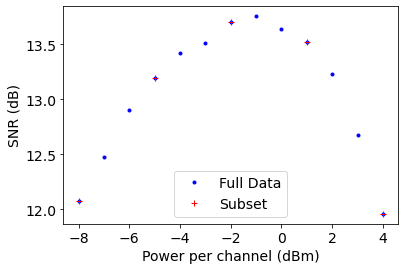

In [3]:
inds = [0, 3, 6, 9, 12]  # -8 to 4 dBm
snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

Get SSFM simulation predictions and apply TRx B2B noise:

In [4]:
snr_ssfm = np.array([19.49, 20.64, 15.09]) 
pch_ssfm = np.array([ -4, 0, 4])
snr_ssfm_m = np.array([apply_b2b(i, 14.8) for i in snr_ssfm])

Import simple physical model, based on Equation 6 and get optimal values via least squares based on SSFM simulation results with a priori parameter estimates:

In [5]:
sim_model = simple_model()
opt_vals = sim_model.fit(pch_ssfm.reshape(len(pch_ssfm),), snr_ssfm.reshape(len(snr_ssfm),),
                         init_guess = np.array([1e-5, 1e3]))
a_opt, b_opt = opt_vals[0]
pch_sim_comp = np.linspace(pch[0], pch[-1], 30)
snr_sim = snr_simple_gen(pch_sim_comp, a_opt, b_opt, 1, 0.5/3)
print(a_opt)
print(b_opt)

4.175696351100312e-06
4496.438144330627


**Train physics-informed and standard GPs:**

In [6]:
num_pts_phys = 15
seed = 1 # for reproducibility, can fix random seed
pch_gn_david = np.linspace(pch[0], pch[-1], num_pts_phys)
snr_gn_david = snr_simple_gen(pch_gn_david, a_opt, b_opt, seed, 0.5/3)
pch_pred = np.arange(pch[-1], pch[0]+0.1, 0.1)

**Define range of noise standard deviation for testing:**

In [7]:
sig_range = np.arange(0.1, 0.21, 0.01) 
mus, ls, sigs, lmls, pred_stds, mses = hyp_var_sig(sig_range, pch_sub, 15, snr_sub, pch_pred, a_opt, b_opt)
lin_mus = np.exp(mus)
lin_ls = np.exp(ls)
lin_sigs = np.exp(sigs)
lin_mls = np.exp(lmls)

**Figure 8**

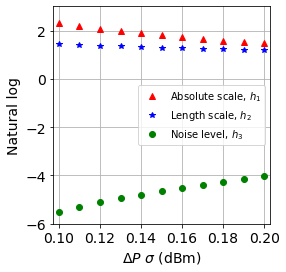

In [8]:
f, ax = plt.subplots()
plt.plot(sig_range, mus, 'r^', label='Absolute scale, $h_1$')
plt.plot(sig_range, ls, 'b*', label='Length scale, $h_2$')
plt.plot(sig_range, sigs, 'go', label='Noise level, $h_3$')
plt.xlim([sig_range[0], sig_range[-1]])
plt.xlim([0.097, 0.203])
plt.xticks([0.10, 0.12, 0.14, 0.16, 0.18, 0.20])
plt.ylim([-6, 3])
plt.xlabel("$\Delta P$ $\sigma$ (dBm)")
plt.ylabel("Natural log")
f.patch.set_facecolor('w')
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.legend( prop={'size':10})
plt.show()

**Figure 9**

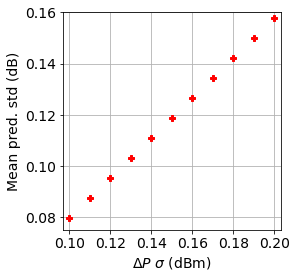

In [9]:
f, ax = plt.subplots()
plt.plot(sig_range, pred_stds, 'rP', label='SSFM')
plt.xlim([0.097, 0.203])
plt.xticks([0.10, 0.12, 0.14, 0.16, 0.18, 0.20])
plt.ylim([0.075, 0.16])
plt.xlabel("$\Delta P$ $\sigma$ (dBm)")
plt.ylabel("Mean pred. std (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.grid()
plt.show()

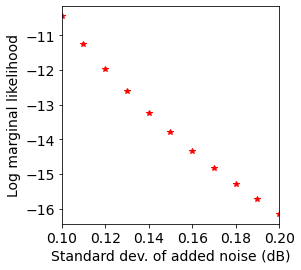

In [10]:
f, ax = plt.subplots()
plt.plot(sig_range, lmls, 'r*')
plt.xlim([sig_range[0], sig_range[-1]])
plt.xlabel("Standard dev. of added noise (dB)")
plt.ylabel("Log marginal likelihood")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.show()

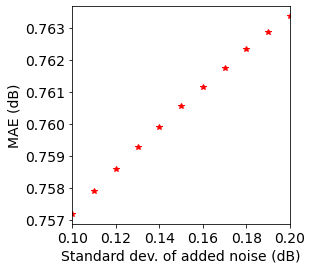

In [11]:
f, ax = plt.subplots()
plt.plot(sig_range, mses, 'r*')
plt.xlim([sig_range[0], sig_range[-1]])
plt.xlabel("Standard dev. of added noise (dB)")
plt.ylabel("MAE (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.show()

**Vary the number of points used in fitting**

In [12]:
num_pts_range = np.arange(2, 41, 2, dtype=int)
mus_p, ls_p, sigs_p, lmls_p, pred_stds_p, mses_p = hyp_var_num_pts(0.5/3, pch_sub, num_pts_range, snr_sub, pch_pred, a_opt, b_opt)
lin_mus = np.exp(mus)
lin_ls = np.exp(ls)
lin_sigs = np.exp(sigs)
lin_mls = np.exp(lmls)

/Users/joshnevin/sklearnforked/scikit-learn/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


The warning is due to the fact that we have trained a PIGP with only 2 physical model data points... Very low values of physical datapoints can lead to instability due to the fact that we have two regressions in the multi task learning framework.

**Figure 10**

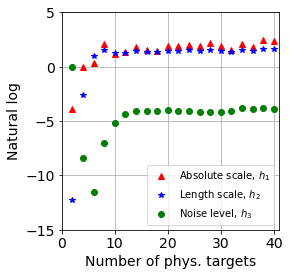

In [13]:
f, ax = plt.subplots()
plt.plot(num_pts_range, mus_p, 'r^', label='Absolute scale, $h_1$')
plt.plot(num_pts_range, ls_p, 'b*', label='Length scale, $h_2$')
plt.plot(num_pts_range, sigs_p, 'go', label='Noise level, $h_3$')
plt.legend(ncol=1, prop={'size':10})
plt.xlim([0, 41])
plt.xticks([0, 10, 20, 30, 40])
plt.ylim([-15, 5])
plt.xlabel("Number of phys. targets")
plt.ylabel("Natural log")
f.patch.set_facecolor('w')
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.show()

**Figure 11**

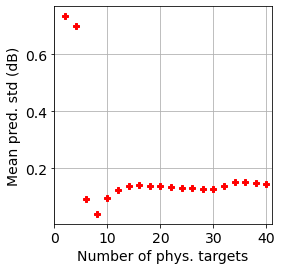

In [14]:
f, ax = plt.subplots()
plt.plot(num_pts_range, pred_stds_p, 'rP', label='SSFM')
plt.xlim([0, 41])
plt.xticks([0, 10, 20, 30, 40])
plt.xlabel("Number of phys. targets")
plt.ylabel("Mean pred. std (dB)")
f.patch.set_facecolor('w')
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.show()

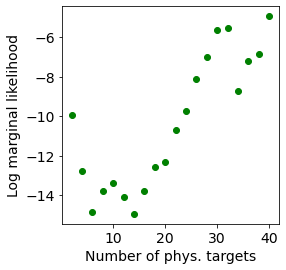

In [15]:
f, ax = plt.subplots()
plt.plot(num_pts_range, lmls_p, 'go')
plt.xlabel("Number of phys. targets")
plt.ylabel("Log marginal likelihood")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.show()

We expect this behaviour, as the log marginal likelihood scales with the number of points - see Rasmussen and Williams, Chapter 5. 

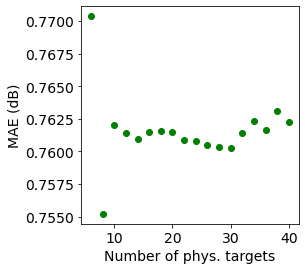

In [16]:
f, ax = plt.subplots()
plt.plot(num_pts_range[2:], mses_p[2:], 'go')
plt.xlabel("Number of phys. targets")
plt.ylabel("MAE (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.show()